In this script, patches of the validation years that are on the same location as one of the trainig patches are saved in on big TFRecord file. These can be predicted by the model as well to see if there's any difference compared with the patches with new locations.
Authenticate to GEE and GCP, install packages

In [ ]:
!pip install --upgrade google-api-python-client   #install Python API
!python -c "from oauth2client import crypt"
!pip install --upgrade earthengine-api==0.1.230
!pip install gcsfs

Requirement already up-to-date: google-api-python-client in /opt/conda/lib/python3.7/site-packages (1.12.5)


In [2]:
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import ee
import pandas as pd
import IPython.display as display

Define bucket and filenames, load high resolution images

In [3]:
available = !gsutil ls -r 'gs://era-ml-upressing/*/*.gz';  #find all documents in bucket that begin with gs://era-ml-upressing/ and end with .gz

In [ ]:
available[8000:10000]

In [4]:
#select files for prediction years:
import re
from sklearn.utils import shuffle
import pandas as pd
years=['1980','1981','1990','1991','2001','2002']
era20_re = re.compile(r'gs://.*ERA20C.*\/(?P<date>\d+)-(?P<scale>\d+km).*')
era5_re = re.compile(r'gs://.*ERA5.*\/(?P<date>\d+)-(?P<scale>\d+km).*')
era20_files = []
for f in available:
  match = era20_re.search(f)    #find all era20 files and save the dates and scale
  if not match:
    continue
  record = match.groupdict()    #dictionary with the dates and scale of file
  record['path'] = f   #add path to dictionary
  if any(record['date'] in d for d in era20_files):
    continue
  elif any(record['date'][:4] in y for y in years):
    era20_files.append(record)
  else:
    continue      #make list of all files and variables (dates and scale)   
era5_files = []
for f in available:
  match = era5_re.search(f)       
  if not match:
    continue
  record = match.groupdict()
  record['path'] = f
  if any(record['date'] in d for d in era5_files):
    continue
  elif any(record['date'][:4] in y for y in years):
    era5_files.append(record)
  else:
    continue
era20_df = pd.DataFrame(era20_files) #show table with path, date, scale
era5_df = pd.DataFrame(era5_files)
pairs_df = pd.merge(era20_df, era5_df, left_on='date', right_on='date', suffixes=['_era20c', '_era5'])  #couple files with same date

In [7]:
pairs_df[730:1460]

,date,scale_era20c,path_era20c,scale_era5,path_era5
730,19900101,120km,gs://era-ml-upressing/ERA20C1990/19900101-120k...,30km,gs://era-ml-upressing/ERA51988-1994/19900101-3...
731,19900102,120km,gs://era-ml-upressing/ERA20C1990/19900102-120k...,30km,gs://era-ml-upressing/ERA51988-1994/19900102-3...
732,19900103,120km,gs://era-ml-upressing/ERA20C1990/19900103-120k...,30km,gs://era-ml-upressing/ERA51988-1994/19900103-3...
733,19900104,120km,gs://era-ml-upressing/ERA20C1990/19900104-120k...,30km,gs://era-ml-upressing/ERA51988-1994/19900104-3...
734,19900105,120km,gs://era-ml-upressing/ERA20C1990/19900105-120k...,30km,gs://era-ml-upressing/ERA51988-1994/19900105-3...
...,...,...,...,...,...
1455,19911227,120km,gs://era-ml-upressing/ERA20C1991/19911227-120k...,30km,gs://era-ml-upressing/ERA51988-1994/19911227-3...
1456,19911228,120km,gs://era-ml-upressing/ERA20C1991/19911228-120k...,30km,gs://era-ml-upressing/ERA51988-1994/19911228-3...
1457,19911229,120km,gs://era-ml-upressing/ERA20C1991/19911229-120k...,30km,gs://era-ml-upressing/ERA51988-1994/19911229-3...
1458,19911230,120km,gs://era-ml-upressing/ERA20C1991/19911230-120k...,30km,gs://era-ml-upressing/ERA51988-1994/19911230-3...


In [22]:
!pip install gcsfs
Username = 'avelon98'
Bucket = 'gs://era-ml-upressing/*/'
filenames_low=list(pairs_df['path_era20c'])
filenames_high=list(pairs_df['path_era5'])
lowResImages = tf.data.TFRecordDataset(filenames_low, compression_type='GZIP')
highResImages = tf.data.TFRecordDataset(filenames_high, compression_type='GZIP')

In [23]:
def parse_example_high(raw_example):
  shape = [512,512,1]
  featuresDict={'total_precipitation': tf.io.FixedLenFeature(shape=shape, dtype=tf.float32),}
  example = tf.io.parse_single_example(raw_example, featuresDict)
  return example['total_precipitation']
  
def parse_example_low(raw_example):
  shape = [128,128,1]
  featuresDict={'b1': tf.io.FixedLenFeature(shape=shape, dtype=tf.float32),}
  example = tf.io.parse_single_example(raw_example, featuresDict)
  return example['b1']

highResImagePatches = highResImages.map(parse_example_high)
lowResImagePatches = lowResImages.map(parse_example_low)

min_list

#Normalilzation data and cutting out patch middle tiles

In [24]:
#Normalilzation data and cutting out patch middle tiles
from sklearn import preprocessing
import functools
import itertools
import pickle


def min_max_scaler(image,shape):
    a = image.numpy()
    flat = np.ndarray.flatten(a)
    b = np.where(flat< 1e-4, 0 , flat)
    c = b**(1/5)
    d = c.reshape(-1,1)  
    scaler = pickle.load(open('scaler_new.pkl', 'rb'))
    e = scaler.transform(d) 
    return e.reshape(shape, shape, 1)

def scaler(patches, shape):
    # loop over patch position
    positions = [
               [],
               [],
               ['mlm'],
               [],
               [],
               [],
               [],
               [],
               [],
               []
    ]
    positions = itertools.cycle(positions)
    for position, patch in zip(positions, patches):
        # loop over subpatches
        processed = min_max_scaler(patch, shape)
        padding = shape // 8
        sub_patches = {}
        # ul [0:64, 0:64]
        sub_patches['ul'] = processed[:-padding*4, :-padding*4]
        # mlm [48:112, 32:96]
        sub_patches['mlm'] = processed[padding*3:-padding*1, padding*2:-padding*2]
        # ll [64:128, 0:64]
        sub_patches['mr'] = processed[padding*2:-padding*2, padding*4:]
        # lr [32:96, 64:128]
        sub_patches['lr'] = processed[padding*4:, padding*4:]

        # mm [32:96, 32:96]
        sub_patches['mm'] = processed[padding*2:-padding*2, padding*2:-padding*2]
        for position_i in position:
            yield sub_patches[position_i]
            
patches_low  = tf.data.Dataset.from_generator(functools.partial(scaler, lowResImagePatches), output_types=tf.float32, output_shapes=[64,64,1], args=[128])
patches_high = tf.data.Dataset.from_generator(functools.partial(scaler, highResImagePatches), output_types=tf.float32, output_shapes=[256, 256,1], args=[512])



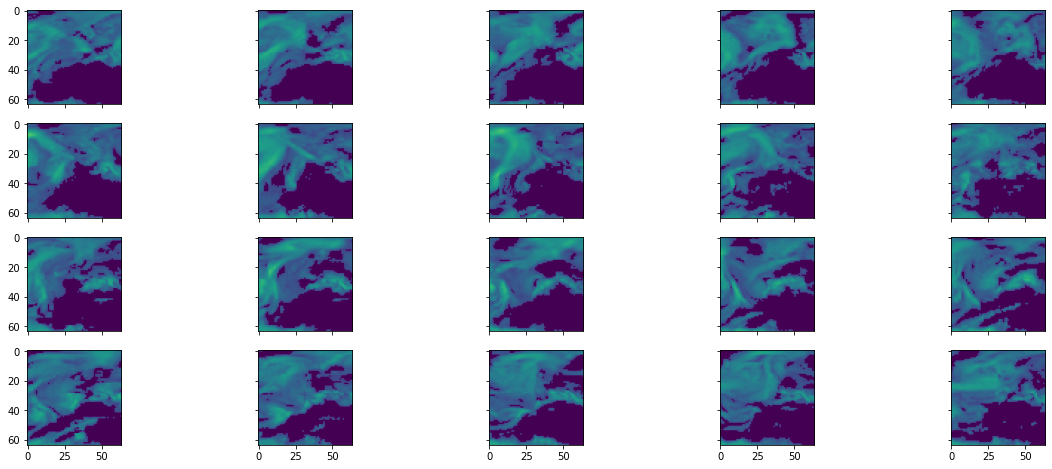

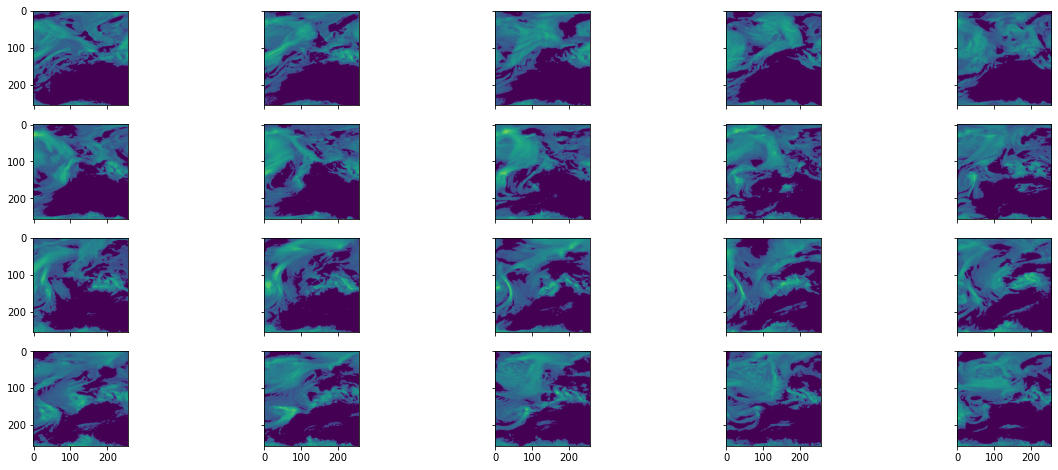

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=5, nrows=4, sharex=True, sharey=True, figsize=(20, 8))
for ax, example in zip(axes.flat, patches_low):
    ax.imshow(example.numpy(), vmin=0, vmax=1)
fig, axes = plt.subplots(ncols=5, nrows=4, sharex=True, sharey=True, figsize=(20, 8))
for ax, example in zip(axes.flat, patches_high):
    ax.imshow(example.numpy(), vmin=0, vmax=1)

In [25]:
#serialize data, so it can be saved as tfrecord file
dataset_low = patches_low.map(tf.io.serialize_tensor)
dataset_high= patches_high.map(tf.io.serialize_tensor)

In [27]:
len(patches_low)

TypeError: dataset length is unknown.

In [28]:
#Save big TFRecord file in Bucket on GCP 
import tqdm
for i, batch in tqdm.tqdm(enumerate(dataset_low.batch(2190))):
    filename_low = f'gs://era-ml-upressing/tfrecord_files_predL/Low-{i}'
    writer_low = tf.data.experimental.TFRecordWriter(filename_low, compression_type='GZIP')

 # Converting `batch` back into a `Dataset`, assuming batch is a `tuple` of `tensors`
    batch_ds = tf.data.Dataset.from_tensor_slices(batch)

    writer_low.write(batch_ds)

for i, batch in tqdm.tqdm(enumerate(dataset_high.batch(438))):
    filename_high = f'gs://era-ml-upressing/tfrecord_files_predH/High-{i}'
    writer_high = tf.data.experimental.TFRecordWriter(filename_high, compression_type='GZIP')

 # Converting `batch` back into a `Dataset`, assuming batch is a `tuple` of `tensors`
    batch_ds = tf.data.Dataset.from_tensor_slices(batch)

    writer_high.write(batch_ds)

1it [05:32, 332.78s/it]
5it [1:00:26, 725.36s/it]
